In [11]:

import pandas as pd
import os
from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/RBI_Excel_Data'

files_to_process = {
    'GSDP_Per_Capita': '/content/drive/MyDrive/RBI_Excel_Data/T26_09122024DD383EE342E24FE78BB07E29EAF0E2E7.XLSX',
    'Literacy_Rate': '/content/drive/MyDrive/RBI_Excel_Data/6T_091220248DDB438F8E2C497E8FF554B50EB84197.XLSX',
    'Infant_Mortality_Rate': '/content/drive/MyDrive/RBI_Excel_Data/11T_09122024107E201762D14193A1FABBB94C650549.XLSX',
    'Life_Expectancy': '/content/drive/MyDrive/RBI_Excel_Data/14T_091220248ADAF4F3543649D0AA7DDBD171C98581.XLSX',
    'Poverty_Rate': '/content/drive/MyDrive/RBI_Excel_Data/17T_0912202462EA272A337C43C69E190BC533E6BA9A.XLSX',
    'Industry_GSVA': '/content/drive/MyDrive/RBI_Excel_Data/T47_091220248D638AC4CC924E77844EF519B59D7F7A.XLSX',
    'Services_GSVA': '/content/drive/MyDrive/RBI_Excel_Data/T55_0912202452665DC4B4514CB694F554C9E0C6A7EA.XLSX',
    'Cropping_Intensity': '/content/drive/MyDrive/RBI_Excel_Data/62T_0912202491E451A7399146258434056A70069513.XLSX',
    'Fertiliser_Consumption': '/content/drive/MyDrive/RBI_Excel_Data/94T_0912202436E5684FED244779961E06CF910D03AC.XLSX',
    'Forest_Cover': '/content/drive/MyDrive/RBI_Excel_Data/104T_091220244E991D8F1356457DB4FC9B23CCF81F31.XLSX',
    'Sex_Ratio': '/content/drive/MyDrive/RBI_Excel_Data/5T_091220240CF2C4427D444756917BB37793E7FD87.XLSX'
}

standard_states = [
    'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana',
    'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
    'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
    'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Andaman & Nicobar Islands', 'Chandigarh',
    'Delhi', 'Jammu & Kashmir', 'Puducherry'
]


df_master = pd.DataFrame(standard_states, columns=['State'])


def process_rbi_file(file_path, indicator_name):

    df_raw = pd.read_excel(file_path, header=None)


    header_row_index = -1
    for i, row in df_raw.head(15).iterrows():
        if any('state' in str(cell).lower() for cell in row):
            header_row_index = i
            break
    if header_row_index == -1: return None

    df = pd.read_excel(file_path, header=header_row_index)

    state_col = None
    for col in df.columns:
        if 'state' in str(col).lower() or 'u.t' in str(col).lower():
            state_col = col
            break
    if state_col is None: return None

    value_col = df.columns[-1]

    if df[value_col].dtype not in ['int64', 'float64']:
        value_col = df.columns[-2]

    # Extract, clean, and rename the essential data
    df_clean = df[[state_col, value_col]].copy()
    df_clean.rename(columns={state_col: 'State', value_col: indicator_name}, inplace=True)
    df_clean.dropna(subset=['State'], inplace=True) # Remove empty rows

    # Clean up state names
    df_clean['State'] = df_clean['State'].astype(str).str.strip()
    # A common issue: RBI files sometimes have numbers in state names. This removes them.
    df_clean['State'] = df_clean['State'].str.replace(r'\d+\.?', '', regex=True).str.strip()

    # Remove summary rows like 'All India'
    df_clean = df_clean[~df_clean['State'].str.contains('All-India', case=False)]

    return df_clean

for indicator, filename in files_to_process.items():
    full_path = os.path.join(folder_path, filename)
    try:
        print(f"Processing: {filename}...")
        df_processed = process_rbi_file(full_path, indicator)

        if df_processed is not None:
            # Handle slight variations in state names before merging
            # (e.g., 'Andaman & Nicobar Islands' vs. 'Andaman and Nicobar Islands')
            df_processed['State'] = df_processed['State'].replace({
                'Andaman & Nicobar Islands': 'Andaman & Nicobar Islands',
                'Jammu & Kashmir': 'Jammu & Kashmir'
            }, regex=False)

            # Merge into the master dataframe
            df_master = pd.merge(df_master, df_processed, on='State', how='left')
            print(f"-> Success!")
        else:
            print(f"-> FAILED: Could not process the file structure.")

    except FileNotFoundError:
        print(f"-> ERROR: File not found! Please check the filename and path: {filename}")
    except Exception as e:
        print(f"-> An unexpected error occurred: {e}")


df_master.set_index('State', inplace=True)

print("\n\n--- Master Dataframe Preview ---")
print(df_master.head())
print(f"\nShape of the final data: {df_master.shape}")

print("\n--- Missing Values Summary ---")
print(df_master.isnull().sum())

# Save your final, clean dataset
df_master.to_csv('indian_states_data_final.csv')
print("\n\n✅ 'indian_states_data_final.csv' has been created successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing: /content/drive/MyDrive/RBI_Excel_Data/T26_09122024DD383EE342E24FE78BB07E29EAF0E2E7.XLSX...
-> Success!
Processing: /content/drive/MyDrive/RBI_Excel_Data/6T_091220248DDB438F8E2C497E8FF554B50EB84197.XLSX...
-> Success!
Processing: /content/drive/MyDrive/RBI_Excel_Data/11T_09122024107E201762D14193A1FABBB94C650549.XLSX...
-> Success!
Processing: /content/drive/MyDrive/RBI_Excel_Data/14T_091220248ADAF4F3543649D0AA7DDBD171C98581.XLSX...
-> Success!
Processing: /content/drive/MyDrive/RBI_Excel_Data/17T_0912202462EA272A337C43C69E190BC533E6BA9A.XLSX...
-> Success!
Processing: /content/drive/MyDrive/RBI_Excel_Data/T47_091220248D638AC4CC924E77844EF519B59D7F7A.XLSX...
-> Success!
Processing: /content/drive/MyDrive/RBI_Excel_Data/T55_0912202452665DC4B4514CB694F554C9E0C6A7EA.XLSX...
-> Success!
Processing: /content/drive/MyDrive/RBI_Excel_Data/62T_0912202491E45

In [12]:
import pandas as pd
import numpy as np


df = pd.read_csv('indian_states_data_final.csv')
df.set_index('State', inplace=True)

print("--- Missing Values Before Cleaning ---")
print(df.isnull().sum())


for col in df.columns:

    df[col] = pd.to_numeric(df[col], errors='coerce')

    if df[col].isnull().any():
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_value:.2f}")

print("\n--- Missing Values After Cleaning ---")
print(df.isnull().sum())

print("\n--- Cleaned Data Preview ---")
print(df.head())

--- Missing Values Before Cleaning ---
GSDP_Per_Capita            0
Literacy_Rate              1
Infant_Mortality_Rate      0
Life_Expectancy           12
Poverty_Rate               1
Industry_GSVA              0
Services_GSVA              0
Cropping_Intensity         3
Fertiliser_Consumption     2
Forest_Cover               0
Sex_Ratio                  1
dtype: int64
Filled missing values in 'Literacy_Rate' with median: 77.15
Filled missing values in 'Infant_Mortality_Rate' with median: 39.50
Filled missing values in 'Life_Expectancy' with median: 64.55
Filled missing values in 'Poverty_Rate' with median: 14.50
Filled missing values in 'Cropping_Intensity' with median: 133.10
Filled missing values in 'Fertiliser_Consumption' with median: 104.45
Filled missing values in 'Forest_Cover' with median: 15701.50
Filled missing values in 'Sex_Ratio' with median: 949.00

--- Missing Values After Cleaning ---
GSDP_Per_Capita           0
Literacy_Rate             0
Infant_Mortality_Rate     0
Li

/tmp/ipython-input-1100165573.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

print("--- Scaled Data Preview ---")
print("Notice how all values are now centered around zero.")
print(df_scaled.head())

--- Scaled Data Preview ---
Notice how all values are now centered around zero.
                   GSDP_Per_Capita  Literacy_Rate  Infant_Mortality_Rate  \
State                                                                      
Andhra Pradesh           -0.151101      -1.247960               0.605721   
Arunachal Pradesh        -0.382344      -1.446872              -0.532669   
Assam                    -0.955708      -0.617056               1.409290   
Bihar                    -1.401266      -1.884966               0.806613   
Chhattisgarh             -0.603448      -0.850137               0.940542   

                   Life_Expectancy  Poverty_Rate  Industry_GSVA  \
State                                                             
Andhra Pradesh           -0.042529      0.303337       0.224318   
Arunachal Pradesh         0.096275     -0.605238      -0.806953   
Assam                    -2.047474      0.110561      -0.480426   
Bihar                    -1.646485      2.725679    

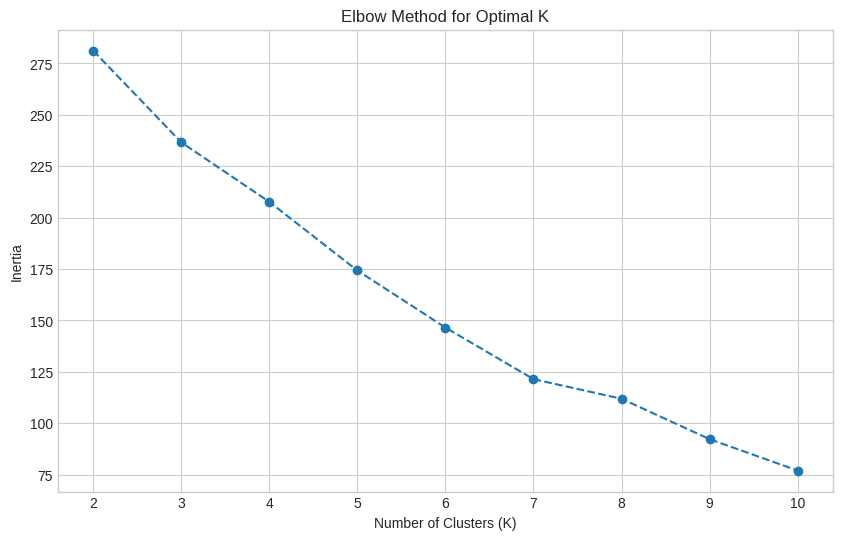

In [14]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia_scores, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [15]:


from sklearn.cluster import KMeans

optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)

df['Cluster'] = clusters

print("--- States and their Assigned Clusters ---")

print(df[['Cluster']].head())

for i in range(optimal_k):
    print(f"\n--- States in Cluster {i} ---")
    print(", ".join(df[df['Cluster'] == i].index))

--- States and their Assigned Clusters ---
                   Cluster
State                     
Andhra Pradesh           3
Arunachal Pradesh        3
Assam                    2
Bihar                    2
Chhattisgarh             3

--- States in Cluster 0 ---
Goa, Andaman & Nicobar Islands, Chandigarh, Delhi

--- States in Cluster 1 ---
Gujarat, Karnataka, Kerala, Maharashtra, Tamil Nadu

--- States in Cluster 2 ---
Assam, Bihar, Madhya Pradesh, Odisha, Rajasthan, Uttar Pradesh

--- States in Cluster 3 ---
Andhra Pradesh, Arunachal Pradesh, Chhattisgarh, Haryana, Himachal Pradesh, Jharkhand, Manipur, Meghalaya, Mizoram, Nagaland, Punjab, Sikkim, Telangana, Tripura, Uttarakhand, West Bengal, Jammu & Kashmir

--- States in Cluster 4 ---
Puducherry



--- Cluster Profiles (Average values for each indicator) ---
         GSDP_Per_Capita  Literacy_Rate  Infant_Mortality_Rate  \
Cluster                                                          
0           92089.750000      86.897500              24.000000   
1           48933.200000      81.966000              32.000000   
2           20946.333333      68.331667              61.166667   
3           36142.529412      76.227941              39.617647   
4           74201.000000      85.850000              22.000000   

         Life_Expectancy  Poverty_Rate  Industry_GSVA  Services_GSVA  \
Cluster                                                                
0              64.550000      3.375000   8.150972e+05   3.320378e+06   
1              67.980000    114.360000   1.002239e+07   1.735572e+07   
2              58.983333    266.583333   4.048162e+06   6.982140e+06   
3              64.900000     27.811765   1.879427e+06   3.133630e+06   
4              64.550000      2.400000   3.

/tmp/ipython-input-773165597.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profile.index, y=cluster_profile[col], ax=axes[i], palette='viridis')
/tmp/ipython-input-773165597.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profile.index, y=cluster_profile[col], ax=axes[i], palette='viridis')
/tmp/ipython-input-773165597.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_profile.index, y=cluster_profile[col], ax=axes[i], palette='viridis')
/tmp/ipython-input-773165597.py:14: FutureWarning: 

Passing 

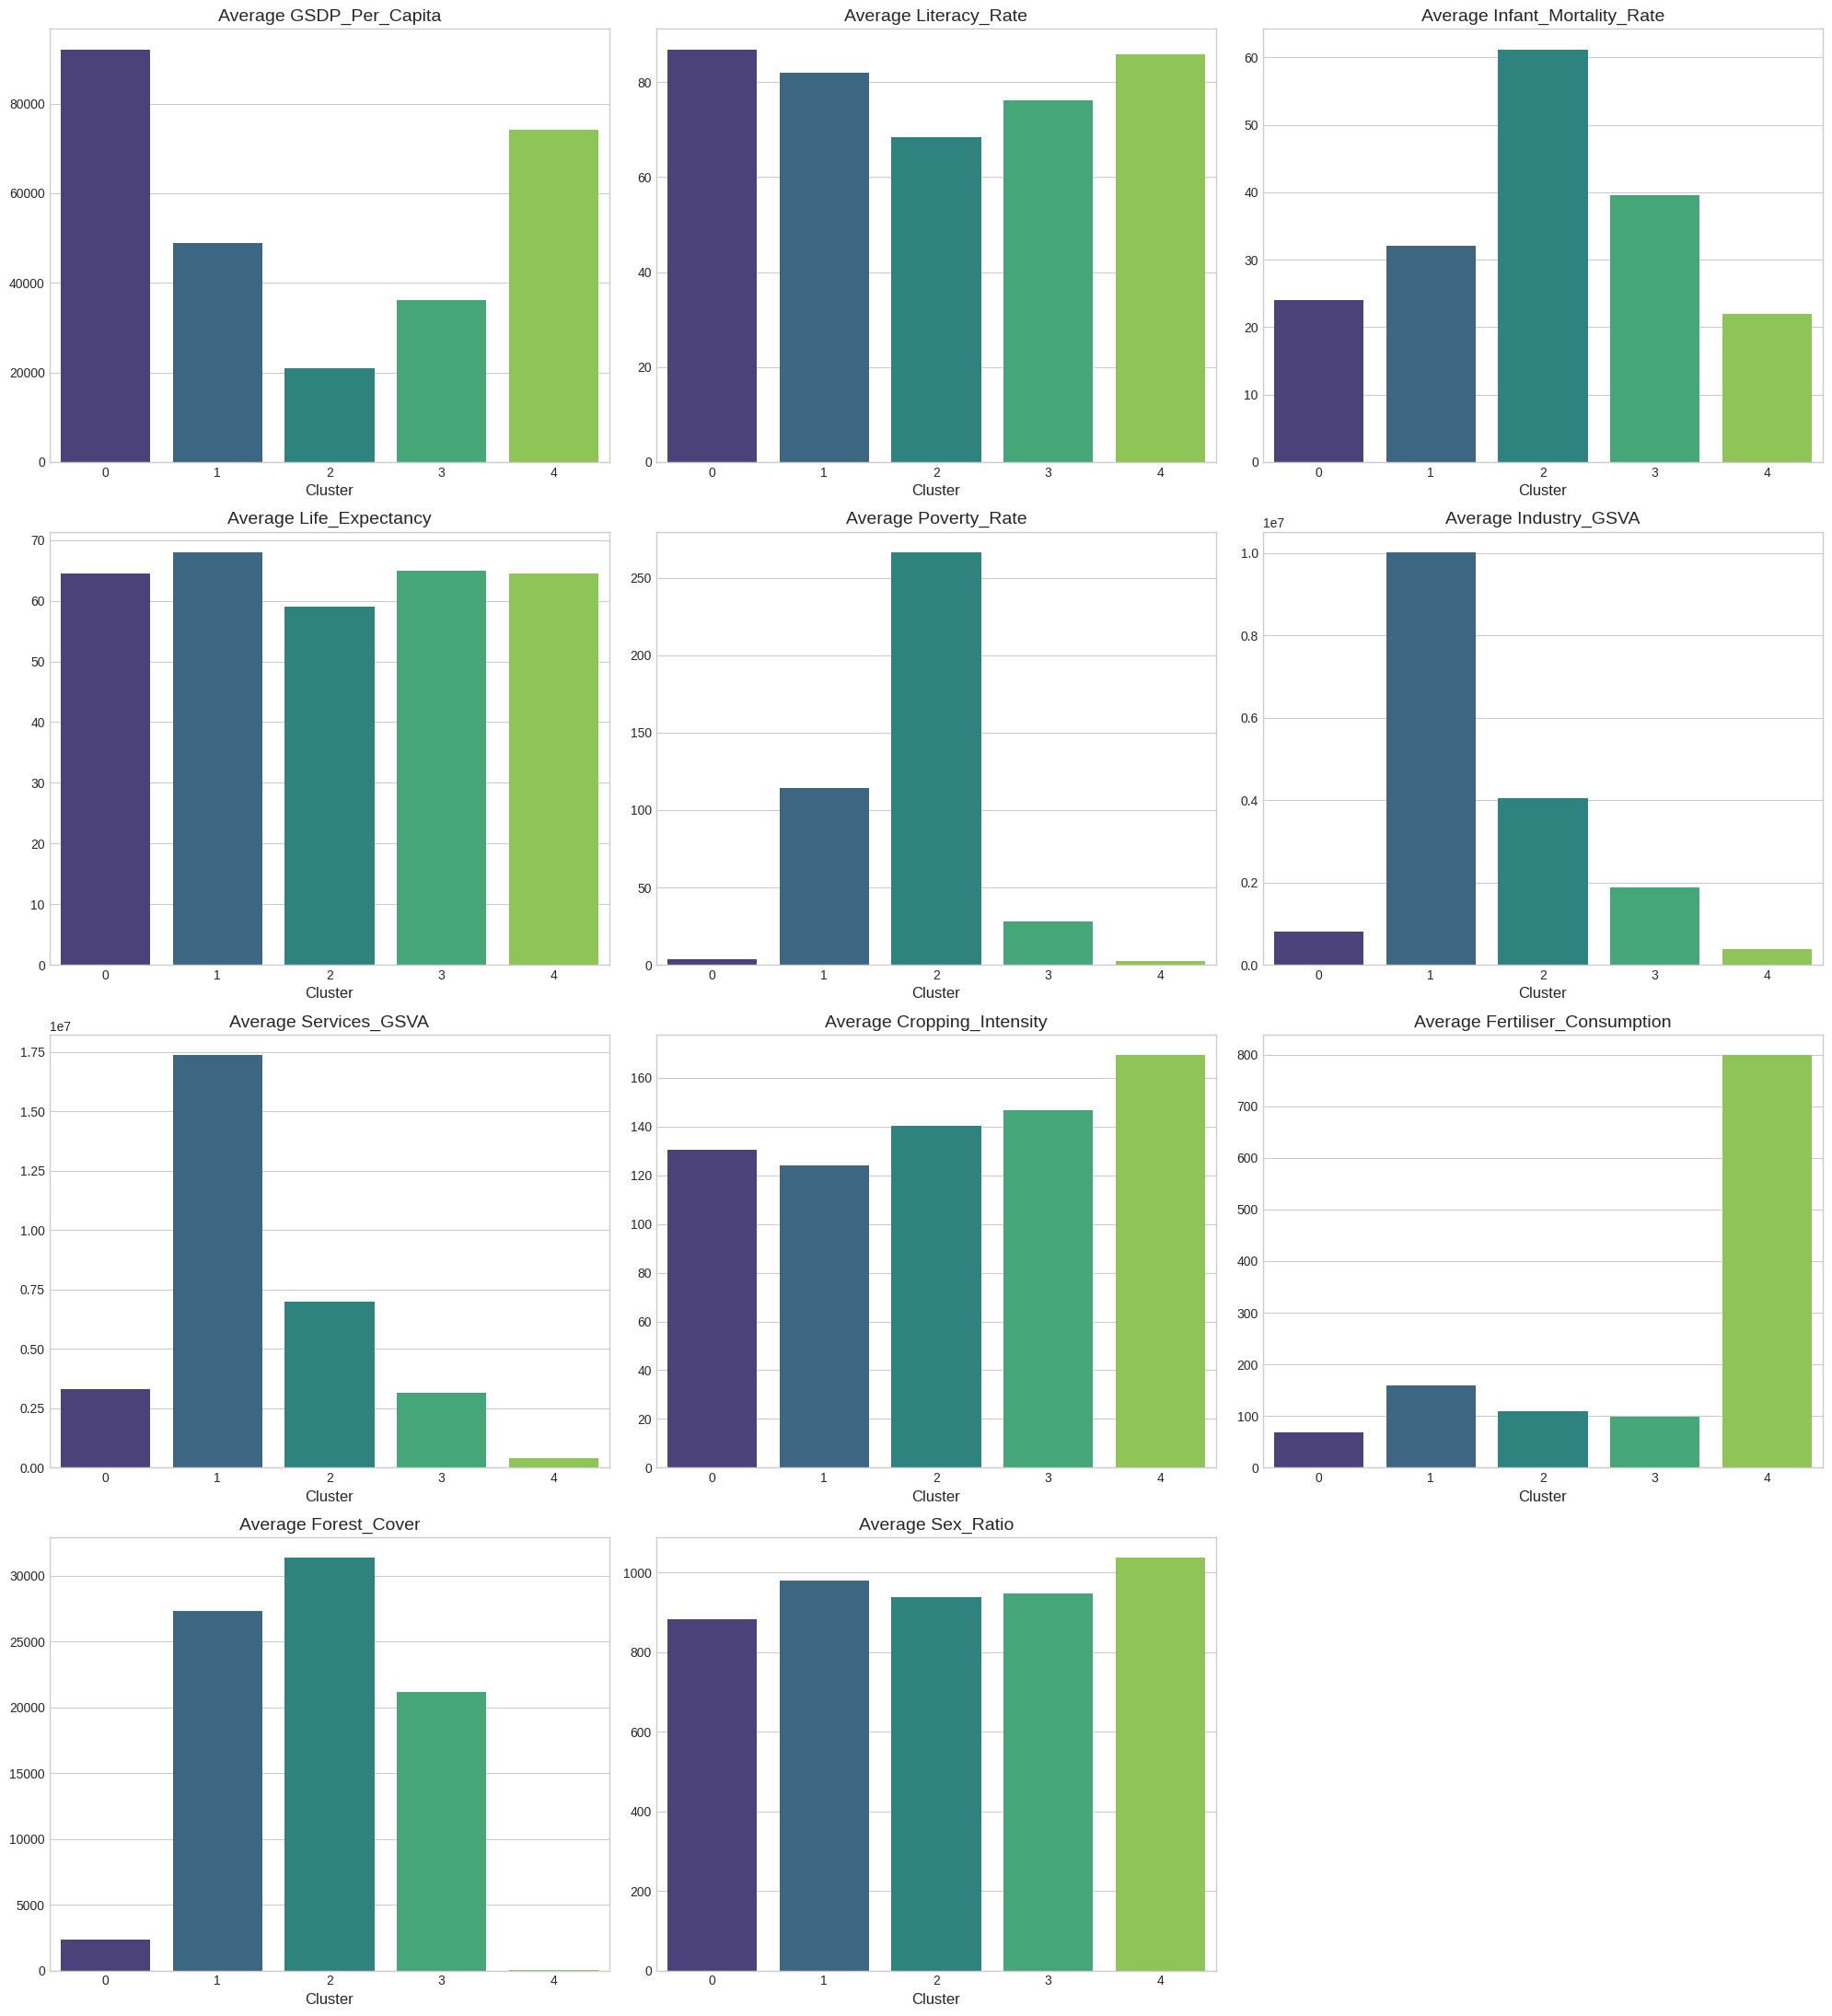

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_profile = df.groupby('Cluster').mean()

print("\n--- Cluster Profiles (Average values for each indicator) ---")
print(cluster_profile)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(4, 3, figsize=(20, 22))
axes = axes.flatten()

for i, col in enumerate(cluster_profile.columns):
    sns.barplot(x=cluster_profile.index, y=cluster_profile[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Average {col}', fontsize=14)
    axes[i].set_xlabel('Cluster', fontsize=12)
    axes[i].set_ylabel('')

if len(cluster_profile.columns) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

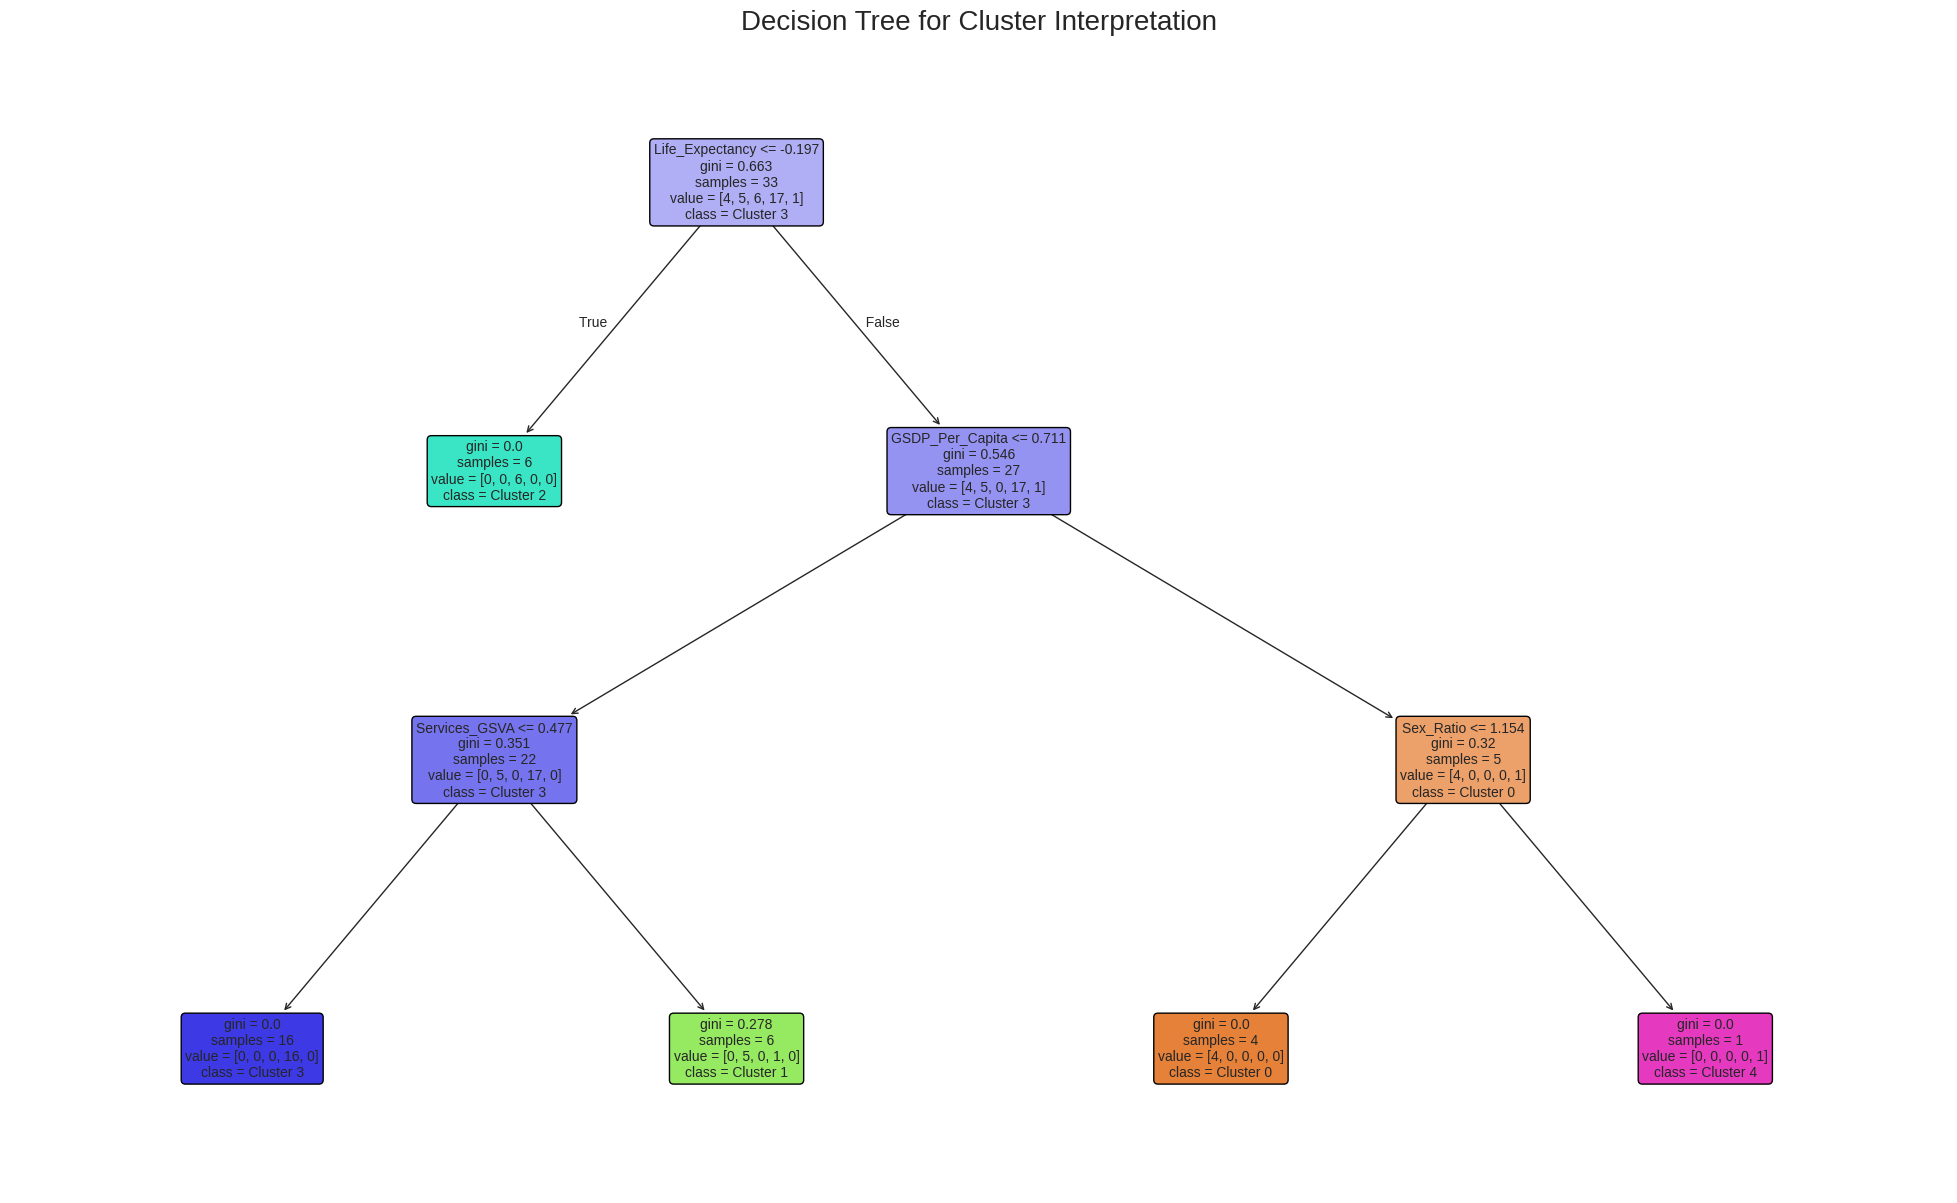

In [17]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = df_scaled
y = df['Cluster']

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(25, 15))
plot_tree(tree, feature_names=df.columns[:-1], class_names=[f"Cluster {i}" for i in range(optimal_k)], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for Cluster Interpretation", fontsize=20)
plt.show()

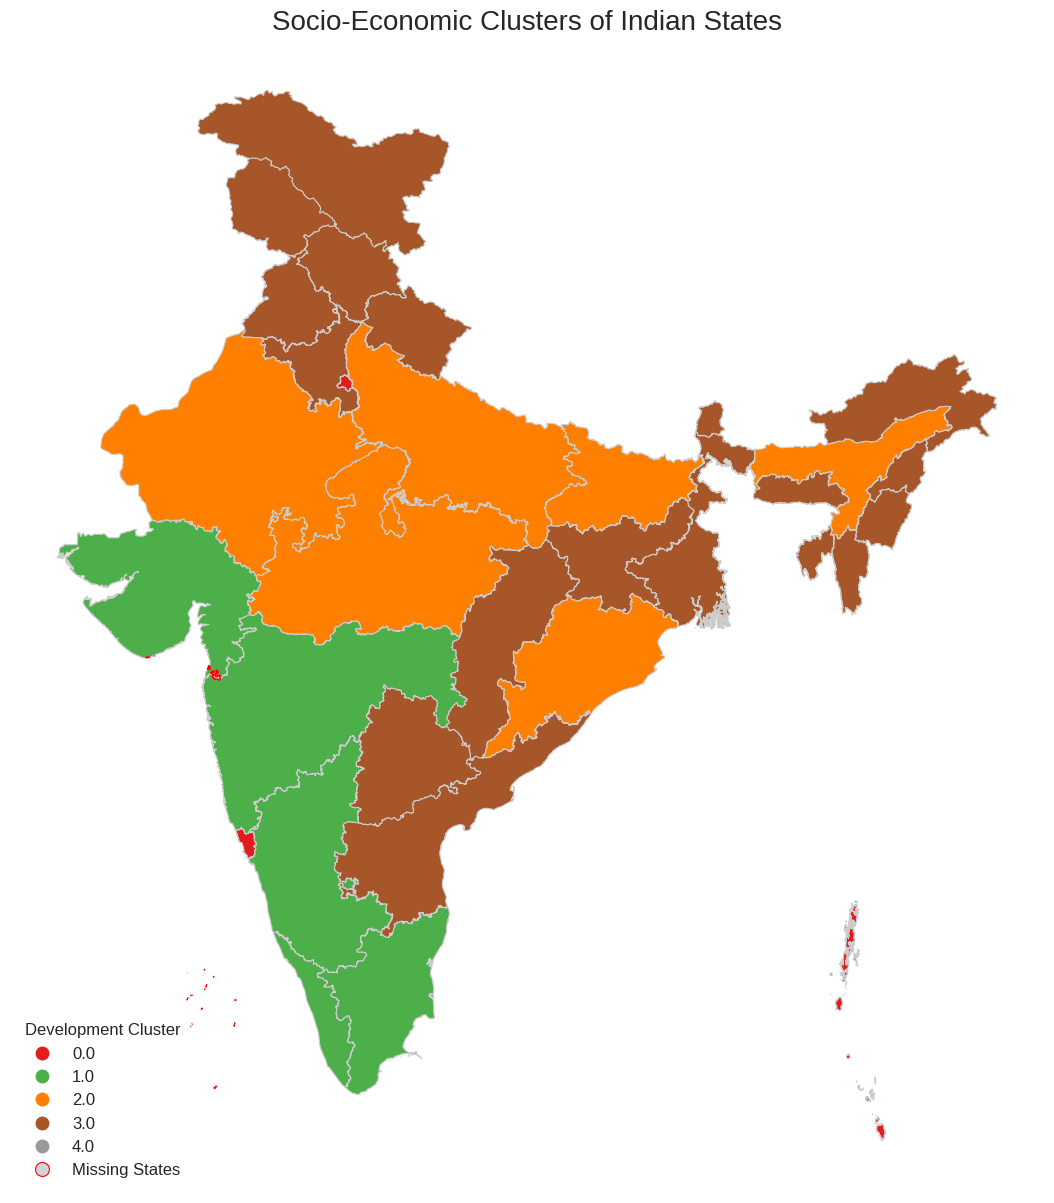


⚠️ The following states are still missing after final merge: ['Dadra And Nagar Haveli', 'Lakshadweep']


In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

try:
    # --- 1. DATA LOADING AND CLUSTERING ---

    # NOTE: Assuming 'indian_states_data_final.csv' is available
    df = pd.read_csv('indian_states_data_final.csv', index_col='State')

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)

    # Scaling and Clustering
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

    optimal_k = 5
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df_scaled)
    df['Cluster'] = clusters

    # --- 2. GEOGRAPHIC MAPPING ---

    shapefile_path = 'India_State_Boundary.shp'
    india_map = gpd.read_file(shapefile_path)

    # Standardize state names for merging
    india_map['State'] = india_map['Name'].str.title()

    # --- DEFINITIVE NAME MAPPING FIXES ---
    name_mapping = {
        # General Fixes
        'Orissa': 'Odisha',
        'Pondicherry': 'Puducherry',
        'Tamilnadu': 'Tamil Nadu',
        'Telengana': 'Telangana',

        # J&K/UT Fixes
        'Andaman & Nicobar': 'Andaman & Nicobar Islands',
        'Jammu And Kashmir': 'Jammu & Kashmir',
        'Ladakh': 'Jammu & Kashmir',
        'Daman And Diu And Dadra And Nagar Haveli': 'Dadra And Nagar Haveli',

        # *** DELHI FIX: MAP NAME 'Delhi' -> DF NAME 'Nct Of Delhi' ***
        'Delhi': 'Nct Of Delhi',

        # *** CHHATTISGARH FIX: MAP NAME 'Chhattishgarh' -> DF NAME 'Chhattisgarh' ***
        'Chhattishgarh': 'Chhattisgarh',
    }
    india_map['State'] = india_map['State'].replace(name_mapping)

    # Merge Cluster Data
    cluster_mapping_df = df[['Cluster']].reset_index().rename(columns={'index': 'State'})
    # Apply mapping to the DF data too, to ensure consistency
    cluster_mapping_df['State'] = cluster_mapping_df['State'].str.title().replace(name_mapping)

    merged_data = india_map.set_index('State').join(cluster_mapping_df.set_index('State'))

    # --- 3. PLOTTING WITH DISCRETE COLORS ---

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    # Define distinct colors for 5 clusters (using 'Set1' palette for high contrast)
    colors = plt.cm.get_cmap('Set1', optimal_k).colors
    cmap = ListedColormap(colors)

    merged_data.plot(
        column='Cluster',
        cmap=cmap,
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend=True,
        categorical=True,
        # Define legend style
        legend_kwds={'title': "Development Cluster", 'fontsize': 12, 'title_fontsize': 12, 'loc': 'lower left'},
        # Define missing data style
        missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing States"},
    )

    ax.set_title('Socio-Economic Clusters of Indian States', fontdict={'fontsize': 20, 'fontweight': '3'})
    ax.axis('off')
    plt.show()

    # Final check for missing states
    missing_states_after_merge = merged_data[merged_data['Cluster'].isnull()].index.tolist()
    if missing_states_after_merge:
        print(f"\n⚠️ The following states are still missing after final merge: {missing_states_after_merge}")
    else:
        print("\n🎉 All states successfully mapped!")

except Exception as e:
    print(f"An error occurred: {e}")

--- Data Prepared for Clustering ---
Shape: (33, 11)



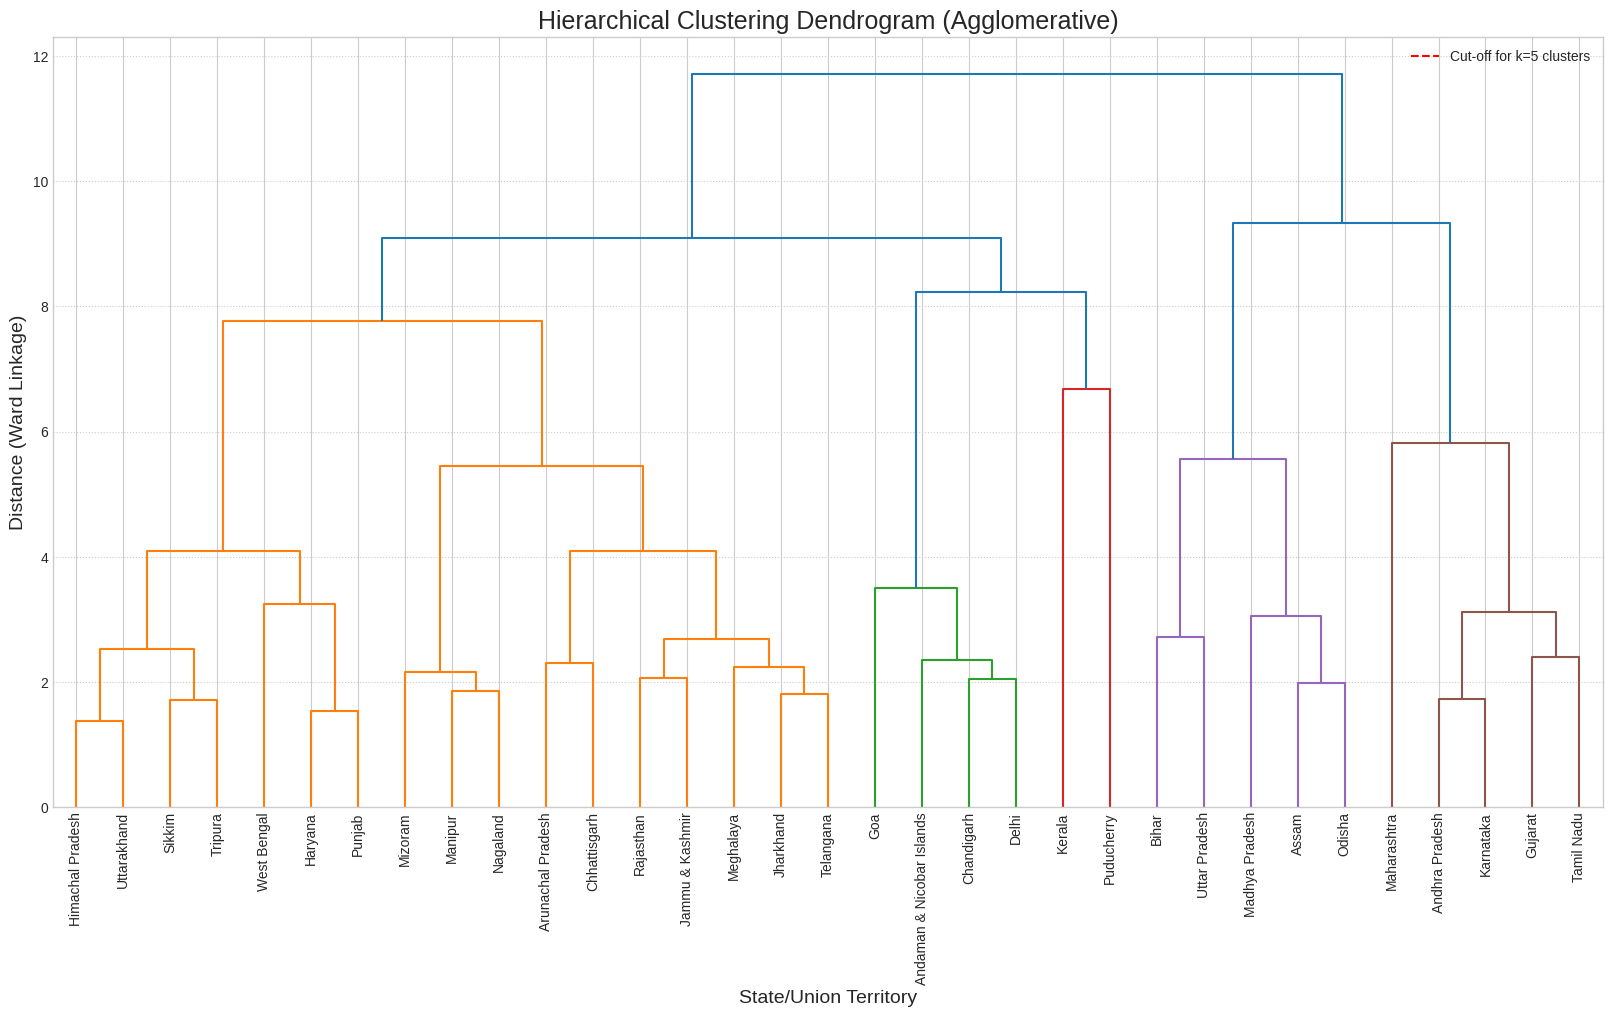

--- Hierarchical Clustering Results ---
Cluster 0 (17 states):
  Arunachal Pradesh, Chhattisgarh, Haryana, Himachal Pradesh, Jharkhand, Manipur, Meghalaya, Mizoram, Nagaland, Punjab, Rajasthan, Sikkim, Telangana, Tripura, Uttarakhand, West Bengal, Jammu & Kashmir
Cluster 1 (2 states):
  Kerala, Puducherry
Cluster 2 (5 states):
  Assam, Bihar, Madhya Pradesh, Odisha, Uttar Pradesh
Cluster 3 (5 states):
  Andhra Pradesh, Gujarat, Karnataka, Maharashtra, Tamil Nadu
Cluster 4 (4 states):
  Goa, Andaman & Nicobar Islands, Chandigarh, Delhi


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans



# Load the cleaned data
df = pd.read_csv('indian_states_data_final.csv', index_col='State')


for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)


scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

print("--- Data Prepared for Clustering ---")
print(f"Shape: {df_scaled.shape}\n")



k_opt = 5 # Use the same k for comparison


Z = linkage(df_scaled, method='ward')


# 2. Visualize the Dendrogram
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Agglomerative)', fontsize=18)
plt.xlabel('State/Union Territory', fontsize=14)
plt.ylabel('Distance (Ward Linkage)', fontsize=14)
dendrogram(
    Z,
    leaf_rotation=90.,  # Rotate the labels for readability
    leaf_font_size=10., # Font size of state names
    labels=df_scaled.index.tolist(),
    truncate_mode='none' # Show all labels
)
# Draw a horizontal line to suggest the cutting point for 5 clusters
plt.axhline(y=15, color='r', linestyle='--', label=f'Cut-off for k={k_opt} clusters')
plt.legend()
plt.grid(axis='y', linestyle='dotted')
plt.show()



# 3. Apply Agglomerative Clustering to get the final cluster labels
agg_clustering = AgglomerativeClustering(n_clusters=k_opt, linkage='ward')
hierarchical_clusters = agg_clustering.fit_predict(df_scaled)

df['Hierarchical_Cluster'] = hierarchical_clusters
print("--- Hierarchical Clustering Results ---")
for i in range(k_opt):
    print(f"Cluster {i} ({len(df[df['Hierarchical_Cluster'] == i])} states):")
    print("  " + ", ".join(df[df['Hierarchical_Cluster'] == i].index.tolist()))

In [20]:

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
kmeans_clusters = kmeans.fit_predict(df_scaled)



metrics = {}


metrics['K-Means_Silhouette'] = silhouette_score(df_scaled, kmeans_clusters)
metrics['Hierarchical_Silhouette'] = silhouette_score(df_scaled, hierarchical_clusters)

metrics['K-Means_DaviesBouldin'] = davies_bouldin_score(df_scaled, kmeans_clusters)
metrics['Hierarchical_DaviesBouldin'] = davies_bouldin_score(df_scaled, hierarchical_clusters)



comparison_df = pd.DataFrame.from_dict(
    {
        'Metric': ['Silhouette Score (Higher is better)', 'Davies-Bouldin Index (Lower is better)'],
        'K-Means': [metrics['K-Means_Silhouette'], metrics['K-Means_DaviesBouldin']],
        'Hierarchical': [metrics['Hierarchical_Silhouette'], metrics['Hierarchical_DaviesBouldin']]
    }
).set_index('Metric')

print("\n\n--- Comparative Cluster Validity Analysis (K-Means vs. Hierarchical) ---")
print(comparison_df.round(3))


better_silhouette = 'K-Means' if metrics['K-Means_Silhouette'] > metrics['Hierarchical_Silhouette'] else 'Hierarchical'
better_db = 'K-Means' if metrics['K-Means_DaviesBouldin'] < metrics['Hierarchical_DaviesBouldin'] else 'Hierarchical'

print(f"\nConclusion based on metrics:")
print(f"* **Silhouette Score suggests {better_silhouette} is better.**")
print(f"* **Davies-Bouldin Index suggests {better_db} is better.**")
print("\nThis conflicting result requires deeper analysis of cluster profiles and visualization.")



--- Comparative Cluster Validity Analysis (K-Means vs. Hierarchical) ---
                                        K-Means  Hierarchical
Metric                                                       
Silhouette Score (Higher is better)       0.189         0.199
Davies-Bouldin Index (Lower is better)    1.120         1.221

Conclusion based on metrics:
* **Silhouette Score suggests Hierarchical is better.**
* **Davies-Bouldin Index suggests K-Means is better.**

This conflicting result requires deeper analysis of cluster profiles and visualization.
